In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd

In [ ]:
!wget -O train.csv https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Monthly-train.csv

--2022-04-08 22:09:51--  https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Monthly-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91655432 (87M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  87.41M  87.7MB/s    in 1.0s    

2022-04-08 22:09:53 (87.7 MB/s) - ‘train.csv’ saved [91655432/91655432]



In [ ]:
history_length = 106
forecast_length = 24

In [ ]:
def load_data():
  train_series = pd.read_csv("train.csv")
  train_series = train_series.iloc[: , 1:].values
  
  history_data = []
  for idx,x in enumerate(train_series):
    x = np.array(x)
    x = x[~np.isnan(x)]
    min_val = min(x) *0.9
    max_val = max(x) * 1.1
    x = ((np.array(x) - min_val) / (max_val - min_val) )
    if(x.shape[0]>history_length + forecast_length):
      history_data.append(x[-(history_length + forecast_length):])
  print(len(history_data))
  history_data = torch.tensor(history_data)
  return history_data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
history_data = load_data()

32133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


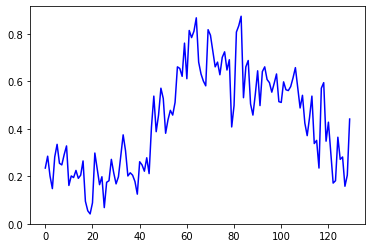

In [ ]:
idx = 1
plt.plot(np.arange(history_length+forecast_length), history_data[idx],color = 'b')
# plt.plot(np.arange(history_length+forecast_length,history_length+2*forecast_length),forecast_data[idx],color = 'g')

# Dataloader

In [ ]:
#!/usr/bin/env python
# coding: utf-8


import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
    
class time_series_decoder_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=history_length,istraining = True,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = history_length
        self.N = len(history_data)
        self.transform = None
        self.train_idx = int(0.8*(len(history_data)))
        self.train_len = self.train_idx + 1
        self.test_len = self.N - self.train_len
        self.x = torch.cat(self.N*[torch.arange(0,history_length+forecast_length).type(torch.float).unsqueeze(0)])
        self.fx = history_data[0:self.N,0:history_length+forecast_length].type(torch.FloatTensor)
        self.masks = self._generate_square_subsequent_mask(t0)
        self.istraining = istraining
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        if self.istraining:
          return self.train_len
        return self.test_len
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if not self.istraining:
          idx = idx + self.train_idx
          


        sample = (self.x[idx,:],
                  self.fx[idx,:],
                  self.masks)

        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(t0+forecast_length,t0+forecast_length)
        for i in range(0,t0):
            mask[i,t0:] = 1 
        for i in range(t0,t0+forecast_length):
            mask[i,i+1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

# Model

In [ ]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self,in_channels=1,embedding_size=256,k=5):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self,x):
        x = self.causal_convolution(x)
        return torch.tanh(x)


In [ ]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = context_embedding(2,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output


In [ ]:
train_dataset = time_series_decoder_paper(istraining = True)
test_dataset = time_series_decoder_paper(istraining = False)

x: 32133*130 fx: 32133*130
x: 32133*130 fx: 32133*130


In [ ]:
len(test_dataset) / 128

50.203125

In [ ]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(test_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])


In [ ]:
def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator


In [ ]:
model = TransformerTimeSeries().to(device)
lr = .0005 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

# Load the checkpoint

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DXljk_8G3H6rpmr--XGh7rrvISqOzagB' -O model_checkpoint.pth

--2022-04-08 22:17:16--  https://docs.google.com/uc?export=download&id=1DXljk_8G3H6rpmr--XGh7rrvISqOzagB
Resolving docs.google.com (docs.google.com)... 74.125.202.101, 74.125.202.138, 74.125.202.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.202.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2pgp8um69pq4mfoclodpn6vdbma19715/1649456175000/07386163179040289899/*/1DXljk_8G3H6rpmr--XGh7rrvISqOzagB?e=download [following]
--2022-04-08 22:17:17--  https://doc-0o-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2pgp8um69pq4mfoclodpn6vdbma19715/1649456175000/07386163179040289899/*/1DXljk_8G3H6rpmr--XGh7rrvISqOzagB?e=download
Resolving doc-0o-6c-docs.googleusercontent.com (doc-0o-6c-docs.googleusercontent.com)... 173.194.194.132, 2607:f8b0:4001:c10::84
Connecting to doc-0o-6c-docs.googleusercontent.com (doc-0o-6c-docs.goo

In [ ]:
# model = torch.load("model_checkpoint.pth")

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,(history_length-1):(history_length+forecast_length-1)],y.cuda()[:,history_length:]) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [ ]:
def test_epoch(model,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            for p,o in zip(output.squeeze()[:,(history_length-1):(history_length+forecast_length-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp


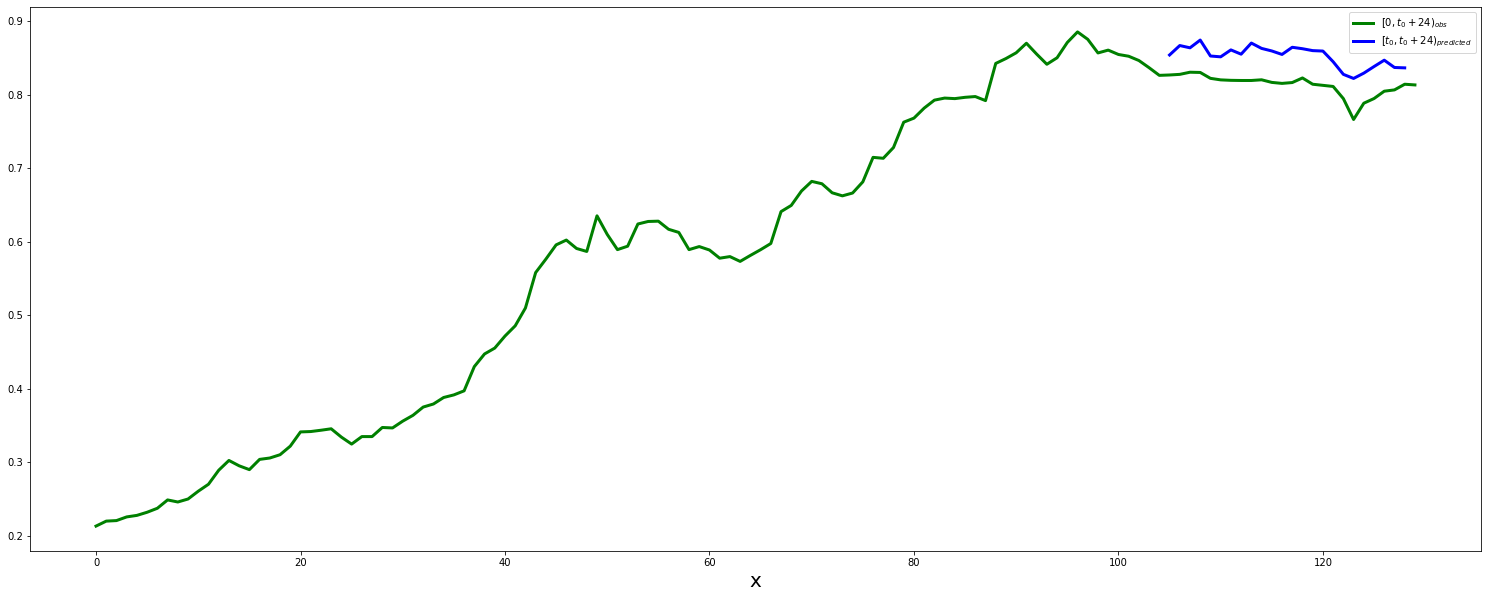

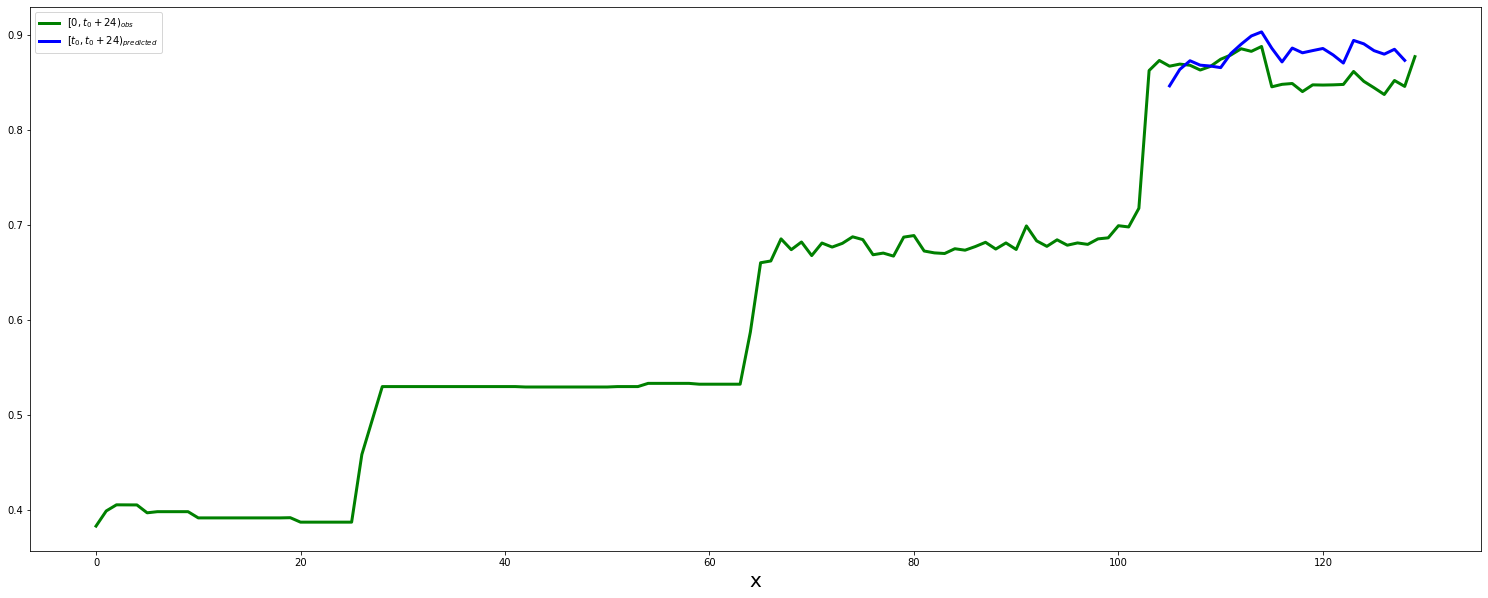

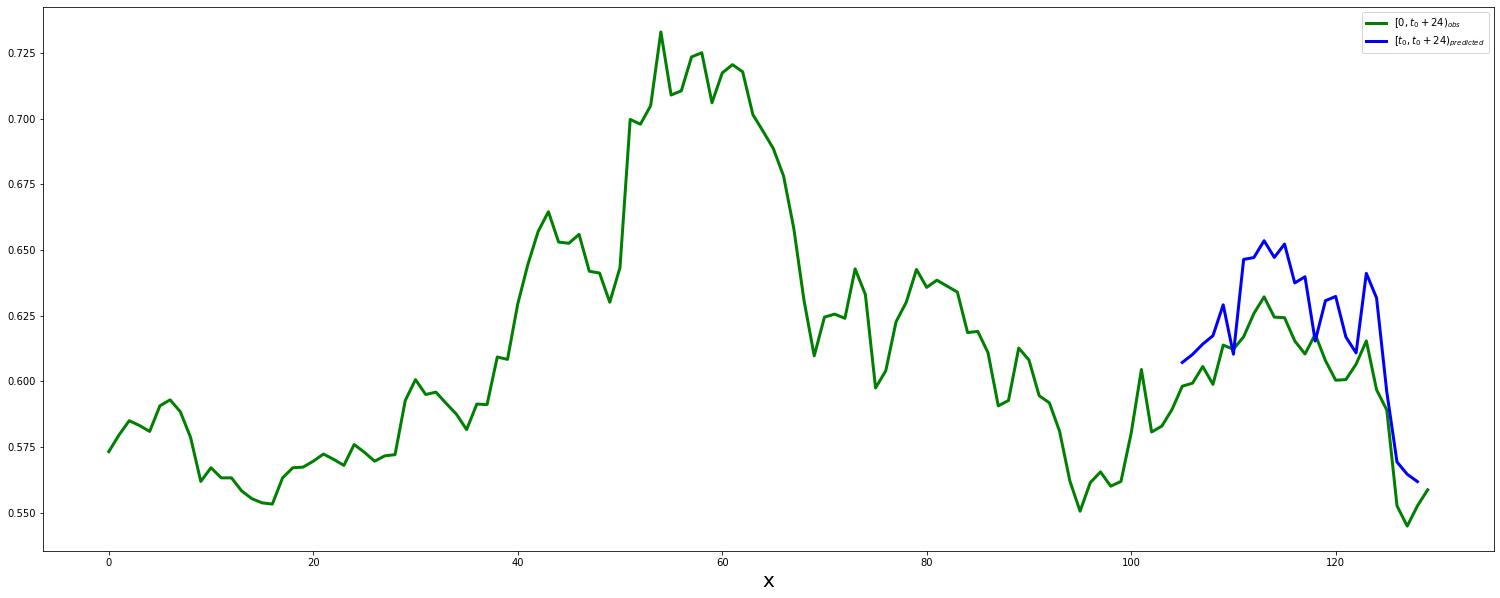

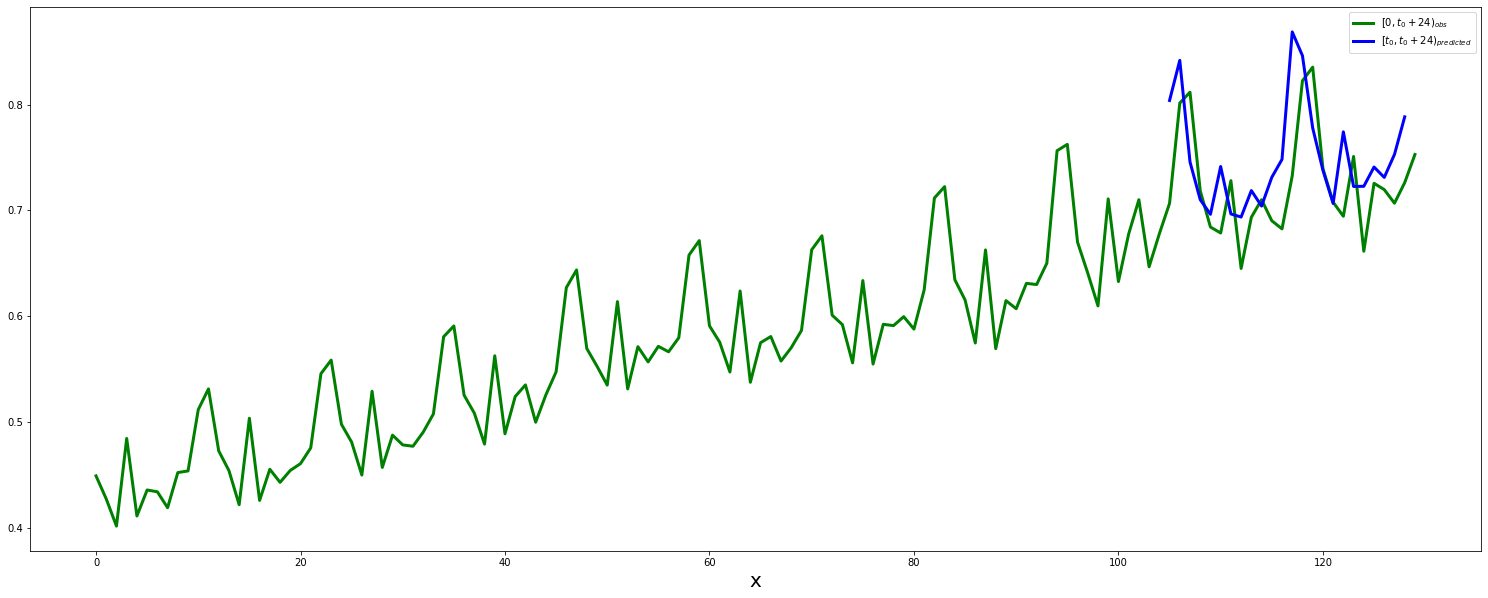

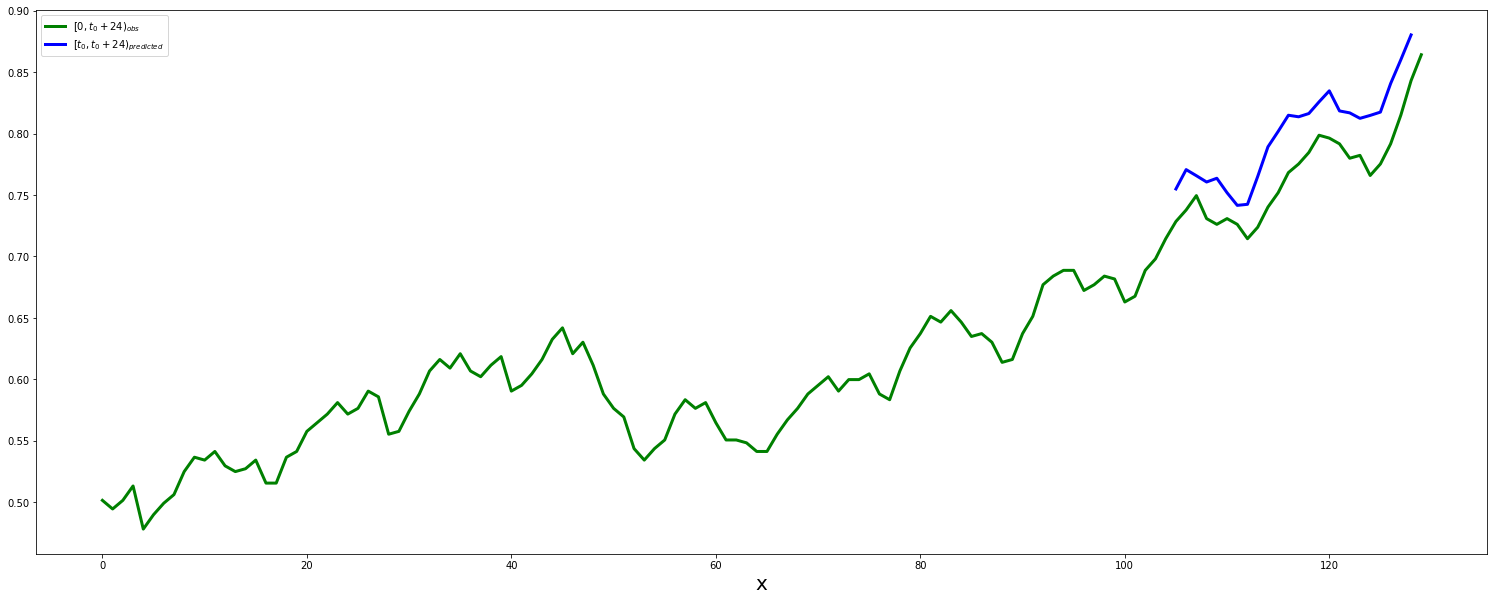

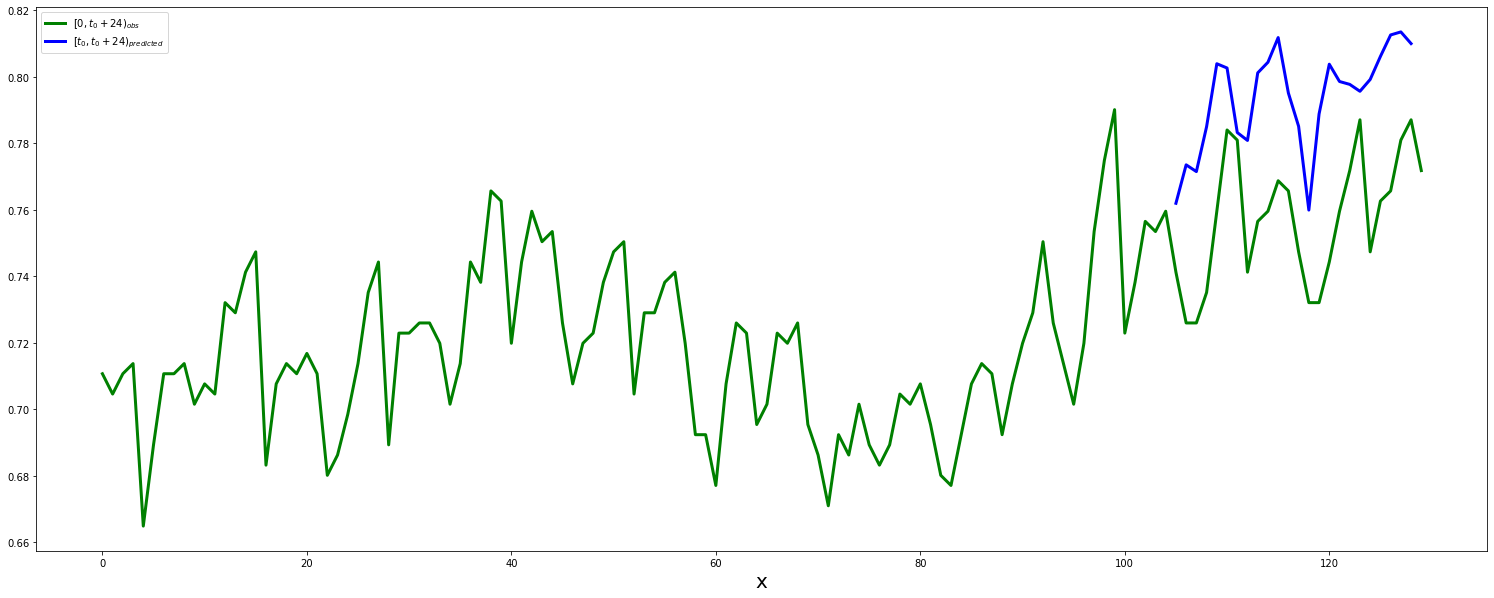

In [ ]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            # print(output.shape)
            # print(output[0,(t0-1):(t0+24-1)].shape)

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(26,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g',linewidth=3)
                plt.plot(x[0,history_length-1:(history_length+forecast_length-1)].cpu().detach().squeeze().numpy(),
                         output[0,(history_length-1):(history_length+forecast_length-1)].cpu().detach().squeeze().numpy(),'b',linewidth=3) # not missing data
                # plt.plot(x[0,(t0-10):(t0+24-10)].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])


In [ ]:
def smape(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

In [ ]:
def find_smape(model):
  smapes = []
  with torch.no_grad():
      model.eval()
      for step,(x,y,attention_masks) in enumerate(test_dl):
              output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
              actual = y[0,(history_length-1):(history_length+24-1)].cpu().detach().squeeze().numpy()
              forecast = output[0,(history_length-1):(history_length+24-1)].cpu().detach().squeeze().numpy()
              smapes.append(smape(actual,forecast))
      
      print(len(smapes))
      return np.mean(smapes)

In [ ]:
find_smape(model)

51


9.696991405650682